In [25]:
import numpy as np

class Sigmoid:
    def forward(self, x):
        self.x = x
        return 1./(1.+np.exp(-x))

    def backward(self, x_grad):
        s = self.forward(self.x)
        return s*(1-s) * x_grad

class Tanh:
    def forward(self, x):
        self.x = x
        return np.tanh(x)

    def backward(self, x_grad):
        e = self.forward(self.x)
        return (1-e**2) * x_grad

class Softmax:
    def forward(self, input_tensor):
        """
        input_tensor: [batch, class]
        """
        exp_x = np.exp(input_tensor)
        self.output = exp_x / np.expand_dims(np.sum(exp_x, axis=1), axis=1)
        return self.output

    def backward(self, output_grad):
        """
        input_tensor: [batch, class]
        """
        input_grad = np.zeros_like(self.output)

        for b in range(self.output.shape[0]):
            for c in range(self.output.shape[1]):
                alpha = -self.output[b]
                alpha[c] = 1 - self.output[b][c]
                alpha *= output_grad[b]
                input_grad[b, c] = np.sum(alpha * self.output[b, c])

        return input_grad
    

class Layer:
    def forward(self, *arge):
        raise NotImplementedError()

    def backward(self, *arge):
        raise NotImplementedError()

    def params(self):
        raise NotImplementedError()

    def params_grad(self):
        raise NotImplementedError()


class Dense(Layer):
    def __init__(self, in_units, out_units, weight=None, bias=None):
        self.in_units = in_units
        self.out_units = out_units
        # 初始化参数
        if weight is not None:
            assert weight.shape == (in_units, out_units), "权重初始值有误"
            self.w = weight
        else:
            self.w = np.random.normal(size=(in_units, self.out_units))
        if bias is not None:
            assert bias.shape == (out_units,), "偏移初始值有误"
            self.b = bias
        else:
            self.b = np.zeros(self.out_units)

    def forward(self, input_tensor):
        assert np.ndim(input_tensor) == 2 and \
               input_tensor.shape[1] == self.in_units, 'Input Tensor should with shape [batch, in_units]'
        self.last_input = input_tensor
        return np.dot(self.last_input, self.w) + self.b

    def backward(self, output_grad):
        self.grad_w = np.dot(self.last_input.T, output_grad)/output_grad.shape[0]
        self.grad_b = np.mean(output_grad, axis=0)
        return np.dot(output_grad, self.w.T)

    def params(self):
        return self.w, self.b

    def params_grad(self):
        try:
            return self.grad_w, self.grad_b
        except BaseException as e:
            print("还没有生成梯度信息！")

In [28]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('../../Mnist_data/', one_hot=True)

dense1 = Dense(784, 30)
s1 = Sigmoid()
dense2 = Dense(30, 10)
s2 = Softmax()

BARCH_SIZE = 10
LEARNING_RATE = 3.

loss_line = []
acc_line = []
for i in range(2000):
    X_train, y_train = mnist.train.next_batch(BARCH_SIZE)
    x = dense1.forward(X_train)
    x = s1.forward(x)
    x = dense2.forward(x)
    x = s2.forward(x)
    
    l = x - y_train
    if i % 50 == 0:
        loss_line.append(np.mean(np.sum((l)**2)/x.shape[0]/2.))
        acc = np.sum(np.argmax(x, axis=1)==np.argmax(y_train, axis=1))/len(y_train)
        acc_line.append(acc)
    
    l = s2.backward(l)
    l = dense2.backward(l)
    l = s1.backward(l)
    l = dense1.backward(l)
    
    for layer in [dense1, dense2]:
        for param, param_grad in zip(layer.params(), layer.params_grad()):
            param -= LEARNING_RATE * param_grad
    

Extracting ../../Mnist_data/train-images-idx3-ubyte.gz
Extracting ../../Mnist_data/train-labels-idx1-ubyte.gz
Extracting ../../Mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../../Mnist_data/t10k-labels-idx1-ubyte.gz


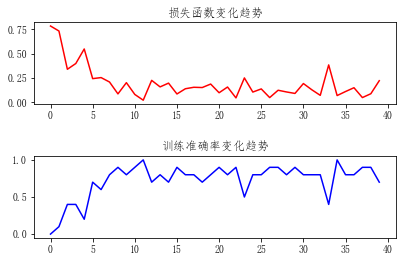

测试准确率为: 83.10%


In [38]:
import matplotlib.pyplot as plt
from pylab import mpl
 
mpl.rcParams['font.sans-serif'] = ['FangSong']    # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False        # 解决保存图像是负号'-'显示为方块的问题　

plt.subplot(211)
plt.plot(list(range(len(loss_line))), loss_line, 'r')
plt.title("损失函数变化趋势")

plt.subplot(212)
plt.plot(list(range(len(acc_line))), acc_line, 'b')
plt.title("训练准确率变化趋势")
plt.tight_layout(2)
plt.show()

X_test, y_test = mnist.train.next_batch(1000)
x = dense1.forward(X_test)
x = s1.forward(x)
x = dense2.forward(x)
x = s2.forward(x)

acc = np.sum(np.argmax(x, axis=1)==np.argmax(y_test, axis=1))/len(y_test)
print("测试准确率为: {:.2f}%".format(100*acc))